# TextLocalization demo02: Class Specific Extremal Regions (NM algorithm)

The main idea behind Class-specific Extremal Regions is similar to the MSER in that suitable Extremal Regions (ERs) are selected from the whole component tree of the image. However, this technique differs from MSER in that selection of suitable ERs is done by a sequential classifier trained for character detection, i.e. dropping the stability requirement of MSERs and selecting class-specific (not necessarily stable) regions.

<img src="images/component_tree.png">

The component tree may conatain a huge number of regions even for a very simple image as shown in the previous image. This number can easily reach the order of 1 x 10^6 regions for an average 1 Megapixel image. In order to efficiently select suitable regions among all the ERs the algorithm make use of a sequential classifier with two differentiated stages.

In the first stage incrementally computable descriptors (area, perimeter, bounding box, and euler number) are computed (in O(1)) for each region r and used as features for a classifier which estimates the class-conditional probability p(r|character). Only the ERs which correspond to local maximum of the probability p(r|character) are selected (if their probability is above a global limit p_min and the difference between local maximum and local minimum is greater than a delta_min value).

In the second stage, the ERs that passed the first stage are classified into character and non-character classes using more informative but also more computationally expensive features. (Hole area ratio, convex hull ratio, and the number of outer boundary inflexion points).

This ER filtering process can be done in different single-channel projections of the input image in order to increase the character localization recall.

### Detect characters in natural scene images

In [6]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [7]:
# load OpenCV python module
import cv2

In [8]:
# load cascade classifier models (two level classification)

erc1 = cv2.text.loadClassifierNM1('./models/trained_classifierNM1.xml')
er1 = cv2.text.createERFilterNM1(erc1,16,0.00015,0.13,0.2,True,0.1)

erc2 = cv2.text.loadClassifierNM2('./models/trained_classifierNM2.xml')
er2 = cv2.text.createERFilterNM2(erc2,0.5)

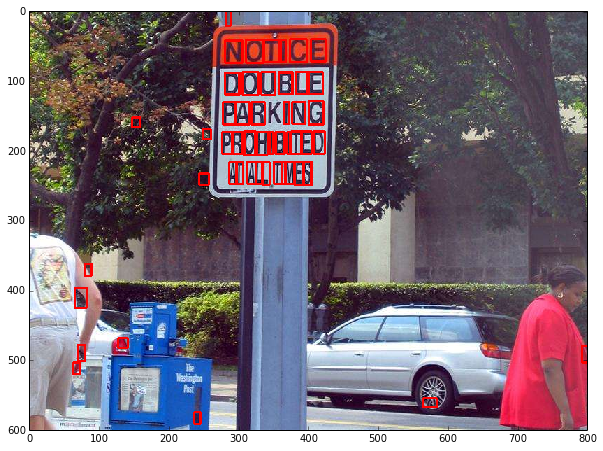

In [9]:
# load the input image
img = cv2.imread('./images/scenetext01.jpg')

# load a grayscale version
gray = cv2.imread('./images/scenetext01.jpg',0)

# detect character candidates (i.e. apply the cascade classifier)
regions = cv2.text.detectRegions(gray,er1,er2)

#Visualization
rects = [cv2.boundingRect(p.reshape(-1, 1, 2)) for p in regions]
for rect in rects:
  cv2.rectangle(img, rect[0:2], (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 255), 2)
img = img[:,:,::-1] #flip the colors dimension from BGR to RGB
plt.imshow(img)

### How does it compare with MSER?

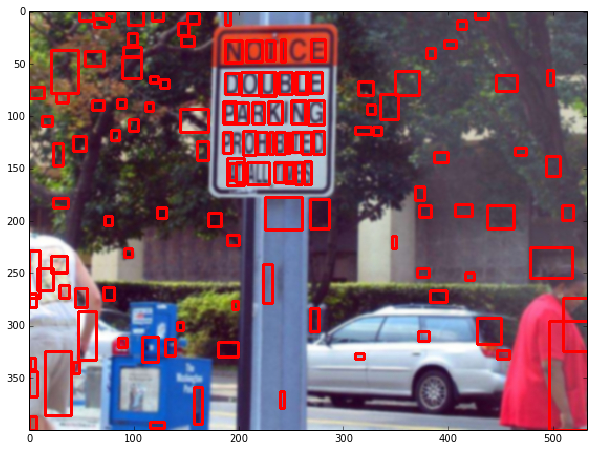

In [10]:
# load the input image
img = cv2.imread('./images/scenetext01_blurred.jpg')

# load a grayscale version
gray = cv2.imread('./images/scenetext01_blurred.jpg',0)

# detect character candidates (i.e. apply the cascade classifier)
regions = cv2.text.detectRegions(gray,er1,er2)

#Visualization
rects = [cv2.boundingRect(p.reshape(-1, 1, 2)) for p in regions]
for rect in rects:
  cv2.rectangle(img, rect[0:2], (rect[0]+rect[2],rect[1]+rect[3]), (0, 0, 255), 2)
img = img[:,:,::-1] #flip the colors dimension from BGR to RGB
plt.imshow(img)

### CSER Parameters and models

The following funtions allow to implicitly load the default classifiers when creating an ERFilter object:

** createERFilterNM1(...) **

    createERFilterNM1(cb[, thresholdDelta[, minArea[, maxArea[, minProbability[, nonMaxSuppression[, minProbabilityDiff]]]]]]) -> retval
    
** createERFilterNM2(...) ** 

    createERFilterNM2(cb[, minProbability]) -> retval
    

Parameters:	

    cb – Callback with the classifier. Default classifier can be implicitly load with function loadClassifierNM1(), e.g. from file in samples/cpp/trained_classifierNM1.xml
    
    thresholdDelta – Threshold step in subsequent thresholds when extracting the component tree
    
    minArea – The minimum area (% of image size) allowed for retreived ER’s
    
    minArea – The maximum area (% of image size) allowed for retreived ER’s
    
    minProbability – The minimum probability P(er|character) allowed for retreived ER’s
    
    nonMaxSuppression – Whenever non-maximum suppression is done over the branch probabilities
    
    minProbability – The minimum probability difference between local maxima and local minima ERs
    
The component tree of the image is extracted by a threshold increased step by step from 0 to 255, incrementally computable descriptors (aspect_ratio, compactness, number of holes, and number of horizontal crossings) are computed for each ER and used as features for a classifier which estimates the class-conditional probability P(er|character). The value of P(er|character) is tracked using the inclusion relation of ER across all thresholds and only the ERs which correspond to local maximum of the probability P(er|character) are selected (if the local maximum of the probability is above a global limit pmin and the difference between local maximum and local minimum is greater than minProbabilityDiff).

         

In the second stage, the ERs that passed the first stage are classified into character and non-character classes using more informative but also more computationally expensive features. The classifier uses all the features calculated in the first stage and the following additional features: hole area ratio, convex hull ratio, and number of outer inflexion points.
